# Exercise 10
## Time Series Analysis & Recurrent Neural Networks, SoSe 2021
### Author: Elias Olofsson
    Version information:
        2021-07-04: v.1.0. First public release. 

In [1]:
import train_lstm as lstm
import train_rnn as rnn

import numpy as np
import matplotlib.pyplot as plt

import torch as tc
import torch.utils.data as data
import torch.nn as nn
import torch.autograd as ag

tc.manual_seed(42)

# Notebook graphics settings: 
%config InlineBackend.figure_format = 'svg' # inline graphics (options: 'svg', 'png', 'retina', etc.)
plt.rcParams['figure.dpi'] = 200            # custom dpi setting for inline png:s

## RNN

In [2]:
net = 'RNN'
# net='LSTM'

'''Initialize Hyperparameters'''
if net == 'RNN':
    hidden_size = 11  # number of hidden units x RNN
else:
    hidden_size = 5   # number of hidden units x LSTM

input_size  = 1    # number of input units
output_size = 1    # number of output units
num_layers  = 1    # number of layers
num_epochs  = 201  # number of times the network is trained
batch_size  = 300  # size of the input data used for one iteration
stretch_length = 500   # length of the interval I use to build mini-batches
learning_rate  = 0.01  # speed of convergence

(20001,)


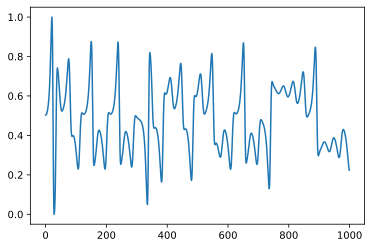

In [3]:
'''load data and divide in training and test set'''
lorenz = np.load('data.npy') # Load the data
print(lorenz.shape)
plt.plot(lorenz[:len(lorenz)//20])

In [4]:
ts_fraction = 0.6
T = len(lorenz)  # Length of time series
T_train = int(ts_fraction*T) # Length of the training set
print(f"""Dataset size: {T}, train/test split: {ts_fraction*100}%
Training set size: {T_train}, Test set size: {T-T_train}""")

# Shift one timestep to create input/output time series. 
inputs  = np.zeros([T-1, input_size])
targets = np.zeros([T-1, input_size])
inputs[:, 0]  = lorenz[:-1] # x_{t}
targets[:, 0] = lorenz[1:]  # x_{t+1}

# Split input/output time series into training and test sets.
input_train  = inputs[:T_train, :]  # training set
target_train = targets[:T_train, :]
input_test   = inputs[T_train:, :]  # test set
target_test  = targets[T_train:, :]

Dataset size: 20001, train/test split: 60.0%
Training set size: 12000, Test set size: 8001


In [5]:
'''Data formatting'''
# transform to tensor format (pytorch)
train_input  = tc.from_numpy(input_train).float()
train_output = tc.from_numpy(target_train).float()

test_input  = tc.from_numpy(input_test).float()
test_output = tc.from_numpy(target_test).float()

# Does a so-called Dataset wrapping (needed for the next step):
train_data = data.TensorDataset(train_input, train_output)
test_data  = data.TensorDataset(test_input, test_output)

print(train_input.shape, train_output.shape, test_input.shape, test_output.shape)

torch.Size([12000, 1]) torch.Size([12000, 1]) torch.Size([8000, 1]) torch.Size([8000, 1])


In [6]:
'''Initialize classes: RNN and LSTM networks '''
# first we initialize how the connections look like defining the weight types and the forward step
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MyRNN, self).__init__()  # Inherited from the parent class nn.Module
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.batch_size  = batch_size
        self.output_size = output_size
        self.num_layers  = num_layers
        self.fc1 = nn.RNN(self.input_size, self.hidden_size, self.num_layers, nonlinearity='relu')
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)  # Define the output layer

    def forward(self, x):  # Forward pass: stacking each layer together
        output, hidden = self.fc1(x)
        output = self.fc2(output)
        return output
    
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, output_size, num_layers):
        super(MyLSTM, self).__init__()
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.batch_size  = batch_size
        self.num_layers  = num_layers

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers)  # Define the LSTM layer
        self.linear = nn.Linear(self.hidden_size, output_size)  # Define the output layer

    def init_hidden(self):
        # Initialization of hidden states
        return (ag.Variable(tc.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                # Variable of Tensor of zeros with dimension (num_layer, bsz, hidden_size)
                ag.Variable(tc.zeros(self.num_layers, self.batch_size, self.hidden_size)))

    def forward(self, input):
        output, hidden = self.lstm(input)
        output = self.linear(output)
        return output

In [7]:
''' Initialize '''
# initialize the network based on parameters:
if net == 'RNN':
    model = MyRNN(input_size, hidden_size, output_size=1, num_layers=1)
else:
    model = MyLSTM(input_size, hidden_size, batch_size, output_size=1, num_layers=1)

In [8]:
print(model)
# compute the number of parameters to be trained (just for personal information,
# it is not relevant for the training itself)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('This model has ' + str(pytorch_total_params) + ' parameters to be trained')

MyRNN(
  (fc1): RNN(1, 11)
  (fc2): Linear(in_features=11, out_features=1, bias=True)
)
This model has 166 parameters to be trained


In [9]:
# choosing loss function
criterion = nn.MSELoss()  # calculates a loss fct per minibatch based on Mean Squared Error
# and optimizer
optimizer = tc.optim.Adam(model.parameters(), lr=learning_rate)  # Adaptive moment estimation
# optimizer = to.optim.SGD(model.parameters(), lr=learning_rate) # Stochastic gradient descent

Epoch  0 MSE:  0.34107932448387146
Epoch  1 MSE:  0.2931590676307678
Epoch  2 MSE:  0.23628854751586914
Epoch  3 MSE:  0.18037177622318268
Epoch  4 MSE:  0.12818573415279388
Epoch  5 MSE:  0.0874769315123558
Epoch  6 MSE:  0.05192645266652107
Epoch  7 MSE:  0.02380678802728653
Epoch  8 MSE:  0.011570708826184273
Epoch  9 MSE:  0.025633443146944046
Epoch  10 MSE:  0.05016779154539108
Epoch  11 MSE:  0.05655984953045845
Epoch  12 MSE:  0.04614880308508873
Epoch  13 MSE:  0.03167622908949852
Epoch  14 MSE:  0.020101506263017654
Epoch  15 MSE:  0.01336369477212429
Epoch  16 MSE:  0.011499011889100075
Epoch  17 MSE:  0.012810059823095798
Epoch  18 MSE:  0.015180527232587337
Epoch  19 MSE:  0.018189577385783195
Epoch  20 MSE:  0.020224813371896744
Epoch  21 MSE:  0.021782858297228813
Epoch  22 MSE:  0.02186298556625843
Epoch  23 MSE:  0.0212022103369236
Epoch  24 MSE:  0.020011819899082184
Epoch  25 MSE:  0.018289683386683464
Epoch  26 MSE:  0.016374029219150543
Epoch  27 MSE:  0.01446888688

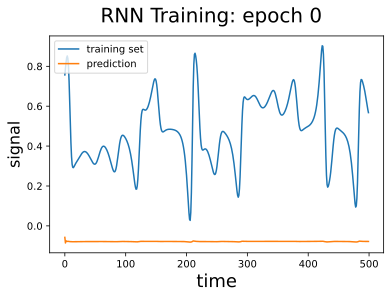

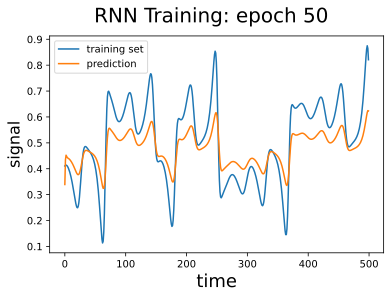

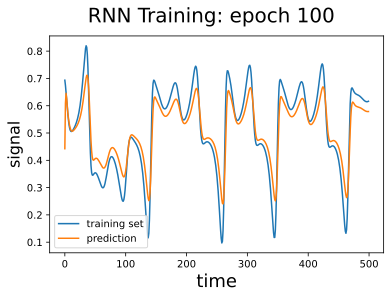

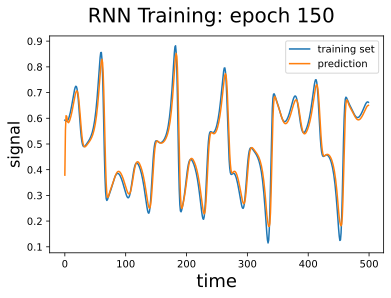

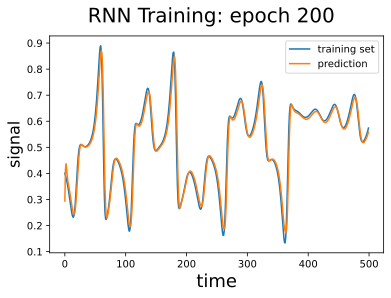

In [10]:
''' Training '''
if net == 'RNN':
    NetParameters, model, hist = rnn.training(criterion, optimizer, train_input, 
                                              train_output, model, num_epochs,
                                              batch_size, stretch_length)
    tc.save(model.state_dict(), 'RNNmodel.pkl')
else:
    NetParameters, model, hist = lstm.training(criterion, optimizer, train_input, 
                                               train_output, model, num_epochs,
                                               batch_size, stretch_length)
    tc.save(model.state_dict(), 'LSTMmodel.pkl')

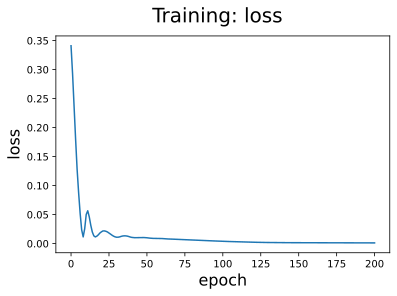

In [11]:
''' print loss'''
plt.figure()
plt.plot(hist)
plt.suptitle('Training: loss', fontsize=20)
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss', fontsize=16)
if net == 'RNN':
    plt.savefig('Training_loss_RNN.png', dpi=300)
else:
    plt.savefig('Training_loss_LSTM.png', dpi=300)

Training set MSE: 0.001219640369527042


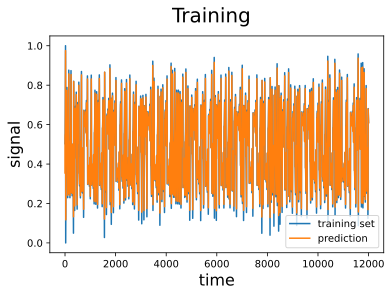

In [12]:
''' plot error predicted and target time series '''
inpt = tc.zeros(train_input.shape[0], 1, 1, dtype=tc.float)
inpt[:, 0, :] = train_input
X_train = ag.Variable(inpt)
Y_train = ag.Variable(train_output)

y_pred = model(X_train)  # apply the trained model to training set

loss = criterion(y_pred.squeeze(), Y_train.squeeze())
print(f'Training set MSE: {loss.item()}')

OT = y_pred.detach().numpy()  # change format to print the time series
TG = Y_train.detach().numpy()

plt.figure()
plt.plot(TG, label='training set')
plt.plot(OT[:, 0, 0], label='prediction')
plt.legend()
plt.suptitle('Training', fontsize=20)
plt.xlabel('time', fontsize=16)
plt.ylabel('signal', fontsize=16)
if net == 'RNN':
    plt.savefig('RNN_Training_prediction.png', dpi=300)
else:
    plt.savefig('LSTM_Training_prediction.png', dpi=300)

Test set MSE: 0.0011407866841182113


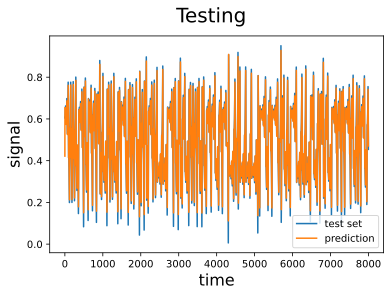

In [13]:
''' plot error predicted and target time series '''
inpt = tc.zeros(test_input.shape[0], 1, 1, dtype=tc.float)
inpt[:, 0, :] = test_input
X_test = ag.Variable(inpt)
Y_test = ag.Variable(test_output)

y_pred = model(X_test)  # apply the trained model to training set

loss = criterion(y_pred.squeeze(), Y_test.squeeze())
print(f'Test set MSE: {loss.item()}')

OT = y_pred.detach().numpy()  # change format to print the time series
TG = Y_test.detach().numpy()

plt.figure()
plt.plot(TG, label='test set')
plt.plot(OT[:, 0, 0], label='prediction')
plt.legend()
plt.suptitle('Testing', fontsize=20)
plt.xlabel('time', fontsize=16)
plt.ylabel('signal', fontsize=16)
if net == 'RNN':
    plt.savefig('RNN_Testing_prediction.png', dpi=300)
else:
    plt.savefig('LSTM_Testing_prediction.png', dpi=300)

In [14]:
# Get multi-step predictions, by iteratively applying the RNNs to their own outputs.
stretch_len = 1000 
batch_size  = 500
n = 50 # Max steps for future predictions.
hist = np.zeros(n)

inputs = tc.zeros(stretch_len+n, batch_size, 1, dtype=tc.float)
target = tc.zeros(stretch_len+n, batch_size, 1, dtype=tc.float)
begin_stretch = np.random.randint(0, len(test_input)-stretch_len-n, batch_size)
for i in range(batch_size):
    inputs[:stretch_len, i, :] = test_input[begin_stretch[i]:begin_stretch[i]+stretch_len, :]
    target[:, i, :] = test_output[begin_stretch[i]:begin_stretch[i]+stretch_len+n, :]

for i in range(stretch_len, stretch_len+n):
    X_test = ag.Variable(inputs[:i])  # Convert input torch tensor to Variable (with gradient and value)
    Y_test = ag.Variable(target[:i])  # same procedure for the precalculated solution
    
    y_pred = model(X_test)
    loss = criterion(y_pred[-1], Y_test[-1])
    hist[i-stretch_len] = loss.item()
    inputs[i] = y_pred[-1]

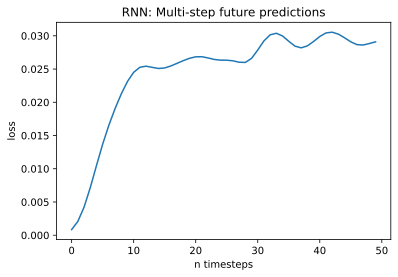

In [15]:
plt.plot(hist)
plt.xlabel('n timesteps')
plt.ylabel('loss')
plt.title('RNN: Multi-step future predictions')
plt.show()

## LSTM

In [16]:
#net = 'RNN'
net = 'LSTM'

'''Initialize Hyperparameters'''
if net == 'RNN':
    hidden_size = 11  # number of hidden units x RNN
else:
    hidden_size = 5   # number of hidden units x LSTM

input_size  = 1    # number of input units
output_size = 1    # number of output units
num_layers  = 1    # number of layers
num_epochs  = 201  # number of times the network is trained
batch_size  = 300  # size of the input data used for one iteration
stretch_length = 500   # length of the interval I use to build mini-batches
learning_rate  = 0.01  # speed of convergence

(20001,)


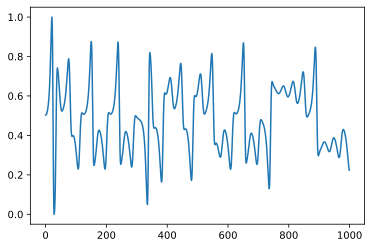

In [17]:
'''load data and divide in training and test set'''
lorenz = np.load('data.npy') # Load the data
print(lorenz.shape)
plt.plot(lorenz[:len(lorenz)//20])

In [18]:
ts_fraction = 0.6
T = len(lorenz)  # Length of time series
T_train = int(ts_fraction*T) # Length of the training set
print(f"""Dataset size: {T}, train/test split: {ts_fraction*100}%
Training set size: {T_train}, Test set size: {T-T_train}""")

# Shift one timestep to create input/output time series. 
inputs  = np.zeros([T-1, input_size])
targets = np.zeros([T-1, input_size])
inputs[:, 0]  = lorenz[:-1] # x_{t}
targets[:, 0] = lorenz[1:]  # x_{t+1}

# Split input/output time series into training and test sets.
input_train  = inputs[:T_train, :]  # training set
target_train = targets[:T_train, :]
input_test   = inputs[T_train:, :]  # test set
target_test  = targets[T_train:, :]

Dataset size: 20001, train/test split: 60.0%
Training set size: 12000, Test set size: 8001


In [19]:
'''Data formatting'''
# transform to tensor format (pytorch)
train_input  = tc.from_numpy(input_train).float()
train_output = tc.from_numpy(target_train).float()

test_input  = tc.from_numpy(input_test).float()
test_output = tc.from_numpy(target_test).float()

# Does a so-called Dataset wrapping (needed for the next step):
train_data = data.TensorDataset(train_input, train_output)
test_data  = data.TensorDataset(test_input, test_output)

print(train_input.shape, train_output.shape, test_input.shape, test_output.shape)

torch.Size([12000, 1]) torch.Size([12000, 1]) torch.Size([8000, 1]) torch.Size([8000, 1])


In [20]:
'''Initialize classes: RNN and LSTM networks '''
# first we initialize how the connections look like defining the weight types and the forward step
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MyRNN, self).__init__()  # Inherited from the parent class nn.Module
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.batch_size  = batch_size
        self.output_size = output_size
        self.num_layers  = num_layers
        self.fc1 = nn.RNN(self.input_size, self.hidden_size, self.num_layers, nonlinearity='relu')
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)  # Define the output layer

    def forward(self, x):  # Forward pass: stacking each layer together
        output, hidden = self.fc1(x)
        output = self.fc2(output)
        return output
    
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, output_size, num_layers):
        super(MyLSTM, self).__init__()
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.batch_size  = batch_size
        self.num_layers  = num_layers

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers)  # Define the LSTM layer
        self.linear = nn.Linear(self.hidden_size, output_size)  # Define the output layer

    def init_hidden(self):
        # Initialization of hidden states
        return (ag.Variable(tc.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                # Variable of Tensor of zeros with dimension (num_layer, bsz, hidden_size)
                ag.Variable(tc.zeros(self.num_layers, self.batch_size, self.hidden_size)))

    def forward(self, input):
        output, hidden = self.lstm(input)
        output = self.linear(output)
        return output

In [21]:
''' Initialize '''
# initialize the network based on parameters:
if net == 'RNN':
    model = MyRNN(input_size, hidden_size, output_size=1, num_layers=1)
else:
    model = MyLSTM(input_size, hidden_size, batch_size, output_size=1, num_layers=1)

In [22]:
print(model)
# compute the number of parameters to be trained (just for personal information,
# it is not relevant for the training itself)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('This model has ' + str(pytorch_total_params) + ' parameters to be trained')

MyLSTM(
  (lstm): LSTM(1, 5)
  (linear): Linear(in_features=5, out_features=1, bias=True)
)
This model has 166 parameters to be trained


In [23]:
# choosing loss function
criterion = nn.MSELoss()  # calculates a loss fct per minibatch based on Mean Squared Error
# and optimizer
optimizer = tc.optim.Adam(model.parameters(), lr=learning_rate)  # Adaptive moment estimation
# optimizer = to.optim.SGD(model.parameters(), lr=learning_rate) # Stochastic gradient descent

Epoch  0 MSE:  0.3412169814109802
Epoch  1 MSE:  0.29780709743499756
Epoch  2 MSE:  0.2577783465385437
Epoch  3 MSE:  0.22156687080860138
Epoch  4 MSE:  0.18791893124580383
Epoch  5 MSE:  0.15801464021205902
Epoch  6 MSE:  0.12926684319972992
Epoch  7 MSE:  0.10402576625347137
Epoch  8 MSE:  0.08211521804332733
Epoch  9 MSE:  0.06279353052377701
Epoch  10 MSE:  0.046253953129053116
Epoch  11 MSE:  0.033366333693265915
Epoch  12 MSE:  0.023463280871510506
Epoch  13 MSE:  0.01891564205288887
Epoch  14 MSE:  0.018739046528935432
Epoch  15 MSE:  0.022221636027097702
Epoch  16 MSE:  0.027795622125267982
Epoch  17 MSE:  0.03297737240791321
Epoch  18 MSE:  0.03488519415259361
Epoch  19 MSE:  0.03448726609349251
Epoch  20 MSE:  0.03296715393662453
Epoch  21 MSE:  0.029568031430244446
Epoch  22 MSE:  0.026589713990688324
Epoch  23 MSE:  0.023427754640579224
Epoch  24 MSE:  0.020580539479851723
Epoch  25 MSE:  0.018745530396699905
Epoch  26 MSE:  0.017954368144273758
Epoch  27 MSE:  0.0175385754

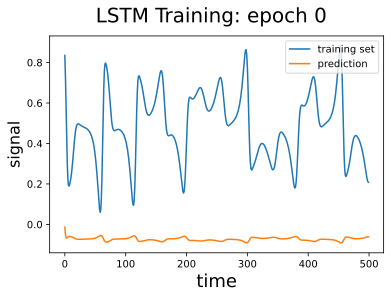

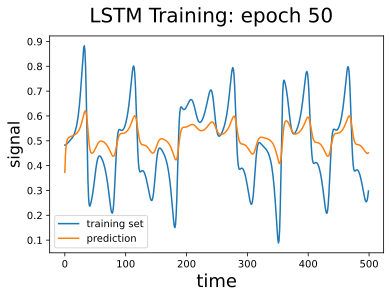

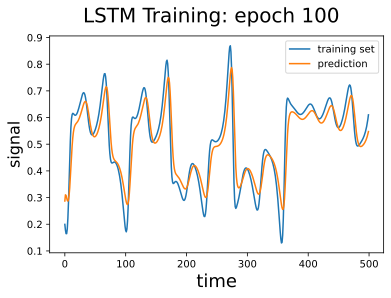

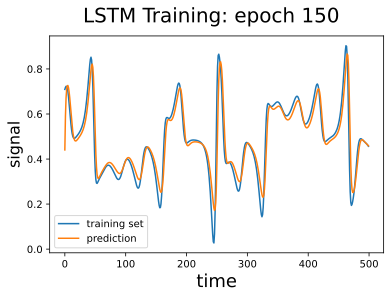

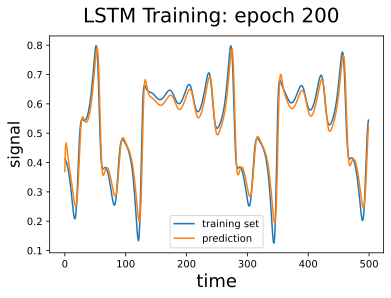

In [24]:
''' Training '''
if net == 'RNN':
    NetParameters, model, hist = rnn.training(criterion, optimizer, train_input, 
                                              train_output, model, num_epochs,
                                              batch_size, stretch_length)
    tc.save(model.state_dict(), 'RNNmodel.pkl')
else:
    NetParameters, model, hist = lstm.training(criterion, optimizer, train_input, 
                                               train_output, model, num_epochs,
                                               batch_size, stretch_length)
    tc.save(model.state_dict(), 'LSTMmodel.pkl')

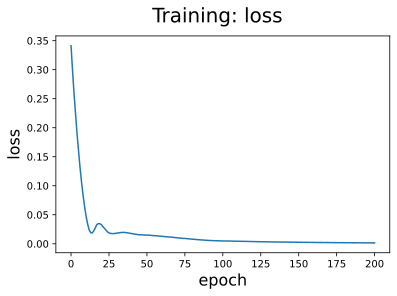

In [25]:
''' print loss'''
plt.figure()
plt.plot(hist)
plt.suptitle('Training: loss', fontsize=20)
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss', fontsize=16)
if net == 'RNN':
    plt.savefig('Training_loss_RNN.png', dpi=300)
else:
    plt.savefig('Training_loss_LSTM.png', dpi=300)

Training set MSE: 0.0015079976292327046


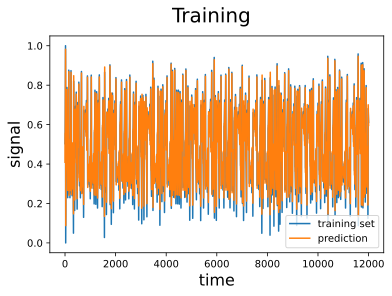

In [26]:
''' plot error predicted and target time series '''
inpt = tc.zeros(train_input.shape[0], 1, 1, dtype=tc.float)
inpt[:, 0, :] = train_input
X_train = ag.Variable(inpt)
Y_train = ag.Variable(train_output)

y_pred = model(X_train)  # apply the trained model to training set

loss = criterion(y_pred.squeeze(), Y_train.squeeze())
print(f'Training set MSE: {loss.item()}')

OT = y_pred.detach().numpy()  # change format to print the time series
TG = Y_train.detach().numpy()

plt.figure()
plt.plot(TG, label='training set')
plt.plot(OT[:, 0, 0], label='prediction')
plt.legend()
plt.suptitle('Training', fontsize=20)
plt.xlabel('time', fontsize=16)
plt.ylabel('signal', fontsize=16)
if net == 'RNN':
    plt.savefig('RNN_Training_prediction.png', dpi=300)
else:
    plt.savefig('LSTM_Training_prediction.png', dpi=300)

Test set MSE: 0.0014512324705719948


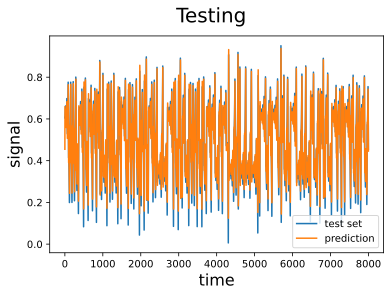

In [27]:
''' plot error predicted and target time series '''
inpt = tc.zeros(test_input.shape[0], 1, 1, dtype=tc.float)
inpt[:, 0, :] = test_input
X_test = ag.Variable(inpt)
Y_test = ag.Variable(test_output)

y_pred = model(X_test)  # apply the trained model to training set

loss = criterion(y_pred.squeeze(), Y_test.squeeze())
print(f'Test set MSE: {loss.item()}')

OT = y_pred.detach().numpy()  # change format to print the time series
TG = Y_test.detach().numpy()

plt.figure()
plt.plot(TG, label='test set')
plt.plot(OT[:, 0, 0], label='prediction')
plt.legend()
plt.suptitle('Testing', fontsize=20)
plt.xlabel('time', fontsize=16)
plt.ylabel('signal', fontsize=16)
if net == 'RNN':
    plt.savefig('RNN_Testing_prediction.png', dpi=300)
else:
    plt.savefig('LSTM_Testing_prediction.png', dpi=300)

In [28]:
# Get multi-step predictions, by iteratively applying the RNNs to their own outputs.
stretch_len = 1000 
batch_size  = 500
n = 50 # Max steps for future predictions.
hist = np.zeros(n)

inputs = tc.zeros(stretch_len+n, batch_size, 1, dtype=tc.float)
target = tc.zeros(stretch_len+n, batch_size, 1, dtype=tc.float)
begin_stretch = np.random.randint(0, len(test_input)-stretch_len-n, batch_size)
for i in range(batch_size):
    inputs[:stretch_len, i, :] = test_input[begin_stretch[i]:begin_stretch[i]+stretch_len, :]
    target[:, i, :] = test_output[begin_stretch[i]:begin_stretch[i]+stretch_len+n, :]

for i in range(stretch_len, stretch_len+n):
    X_test = ag.Variable(inputs[:i])  # Convert input torch tensor to Variable (with gradient and value)
    Y_test = ag.Variable(target[:i])  # same procedure for the precalculated solution
    
    y_pred = model(X_test)
    loss = criterion(y_pred[-1], Y_test[-1])
    hist[i-stretch_len] = loss.item()
    inputs[i] = y_pred[-1]

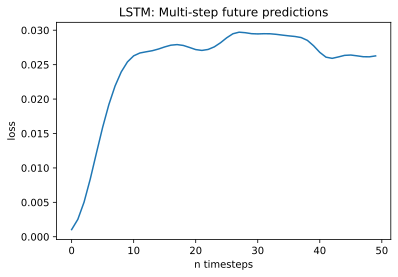

In [29]:
plt.plot(hist)
plt.xlabel('n timesteps')
plt.ylabel('loss')
plt.title('LSTM: Multi-step future predictions')
plt.show()